In [86]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import pickle
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torchaudio.transforms import MelSpectrogram, Spectrogram
from typing import List, Tuple, Dict

from dataclasses import dataclass
from scipy import signal

# Common Variables

In [87]:
DATA_CACHE = Path('../data/cache/')
DATA_RAW = Path('../data/raw/')

EEG_PATH = DATA_RAW / 'train_eegs/'
SPEC_PATH = DATA_RAW / 'train_spectrograms/'

EEG_SAMPLE_RATE = 200           # Hz
EEG_SNIPPET_LEN = 50            # seconds
SPECTROGRAM_SNIPPET_LEN = 600   # seconds

# check if _eegs_raw and _metadata are already loaded
if '_eegs_raw' not in globals() or '_metadata' not in globals():
    _eegs_raw = None
    _metadata = None 

# Dataset Utils

In [88]:
def get_egg_data(use_cache=True):
    global _eegs_raw
    
    if _eegs_raw is not None:
        return _eegs_raw
    
    if use_cache and os.path.exists(DATA_CACHE / 'eegs_raw.pkl'):
        print('Loading EEG data from pickle file')
        _eegs_raw = pickle.load(open(DATA_CACHE / 'eegs_raw.pkl', 'rb'))
        return _eegs_raw
    
    print('Loading EEG data from parquet files')
    train = pd.read_csv(DATA_RAW / 'train.csv')
    _eegs_raw = dict()
    for eeg_id in tqdm(train.eeg_id.unique()):
        _eegs_raw[eeg_id] = get_full_eeg_by_id(eeg_id)

    if use_cache:
        print('Saving eegs_raw to pickle file')
        with open(DATA_CACHE / 'eegs_raw.pkl', 'wb') as f:
            pickle.dump(_eegs_raw, f)

    return _eegs_raw

def get_full_eeg_by_id(eeg_id):
    return get_egg_data()[eeg_id]

def get_snippet_eeg_by_id(eeg_id, eeg_center: float, duration: float = 50):
    eeg = get_egg_data()[eeg_id]
    eeg = eeg.iloc[
        round((eeg_center-duration/2)*EEG_SAMPLE_RATE):
        round((eeg_center+duration/2)*EEG_SAMPLE_RATE)]
    return eeg


def get_full_spectrogram_by_id(spectrogram_id) -> Dict[str, pd.DataFrame]:
    spectrogram_data = pd.read_parquet(f'{SPEC_PATH}/{spectrogram_id}.parquet')

    LL = spectrogram_data.filter(regex='^LL|^(time)$')
    LP = spectrogram_data.filter(regex='^LA|^(time)$')
    RP = spectrogram_data.filter(regex='^RA|^(time)$')
    RL = spectrogram_data.filter(regex='^RL|^(time)$')

    return Spectrograms(
        {'LL': LL, 'LP': RP, 'RP': LP, 'RL': RL}, 
        time = (0, spectrogram_data.time.max()),
    )
    
def get_snippet_spectrogram_by_id(spectrogram_id: int, spectrogram_center: float, duration: float = 50):
    spectrogram_data = pd.read_parquet(f'{SPEC_PATH}/{spectrogram_id}.parquet')
    spectrogram_data = spectrogram_data.loc[
        (spectrogram_data.time>=spectrogram_center-duration/2)&
        (spectrogram_data.time<=spectrogram_center+duration/2)]
    
    LL = spectrogram_data.filter(regex='^LL').T
    LP = spectrogram_data.filter(regex='^LP').T
    RP = spectrogram_data.filter(regex='^RP').T
    RL = spectrogram_data.filter(regex='^RL').T
    
    return Spectrograms(
        {'LL': LL, 'LP': RP, 'RP': LP, 'RL': RL}, 
        time = (spectrogram_data.time.min(), spectrogram_data.time.max()),
    )


def get_metadata():
    global _metadata

    if _metadata is not None:
        return _metadata
    
    print('Loading metadata from parquet file')
    _metadata = pd.read_csv(DATA_RAW / 'train.csv')

    # Add 'center' columns for spectrogram and eeg
    _metadata['eeg_center'] = _metadata.eeg_label_offset_seconds + EEG_SNIPPET_LEN/2
    _metadata['spectrogram_center'] = _metadata.spectrogram_label_offset_seconds + SPECTROGRAM_SNIPPET_LEN/2

    return _metadata

def get_data(row, eeg_duration=50, spec_duration=50):
    eeg = get_snippet_eeg_by_id(row.eeg_id, row.eeg_center, duration=eeg_duration)
    spectrogram = get_snippet_spectrogram_by_id(row.spectrogram_id, row.spectrogram_center, duration=spec_duration)
    return eeg, spectrogram

def convert_to_spectrogram_id(eeg_id):
    metadata = get_metadata()
    metadata = metadata[metadata.eeg_id == eeg_id]
    return metadata.spectrogram_id.values[0]

class Spectrograms:
    _data: Dict[str, pd.DataFrame]

    time: Tuple[float, float]
    frequency: List[float]

    def __init__(self, spectrograms: Dict[str, torch.Tensor] = None, time = None, frequency = None):
        self._data = spectrograms if spectrograms is not None else {}
        self.time = time
        self.frequency = frequency

    def items(self):
        return self._data.items()

    def __getitem__(self, key):
        return self._data[key]

    def __setitem__(self, key, value):
        self._data[key] = value

    def __len__(self):
        return len(self._data)

In [89]:
metadata = get_metadata().iloc[0]

eeg_full = get_full_eeg_by_id(metadata.eeg_id)
eeg_snippet = get_snippet_eeg_by_id(metadata.eeg_id, metadata.eeg_center)
print(metadata.eeg_label_offset_seconds , metadata.eeg_center)
print(metadata.spectrogram_label_offset_seconds , metadata.spectrogram_center)

test_eeg = pd.read_parquet(DATA_RAW / "test_eegs/3911565283.parquet")
test_spec = pd.read_parquet(DATA_RAW / "test_spectrograms/853520.parquet")

print(test_eeg.shape, test_spec.shape)

0.0 25.0
0.0 300.0
(10000, 20) (300, 401)


# Visualization Utils

In [90]:
def visualize_eeg(signal):
    plt.figure(figsize=(10, 5))
    plt.plot(signal)
    plt.title('EEG')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def visualize_spectrogram(signal):
    plt.figure(figsize=(10, 5))
    plt.imshow(signal, aspect='auto', origin='lower', extent=[0, signal.shape[1], 0, signal.shape[0]])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Frequency')
    plt.ylabel('Time')
    plt.show()

def visualize_spectrograms(spectrograms):
    n = len(spectrograms)
    start_time = spectrograms.time[0]
    end_time = spectrograms.time[-1]

    fig, axs = plt.subplots(1, n, figsize=(5*n, 5))
    for i, (k, v) in enumerate(spectrograms.items()):
        axs[i].imshow(v, aspect='auto', origin='lower', extent=[start_time, end_time, 0, 40])
        axs[i].set_title(k)
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Frequency')
    plt.show()



# Spectogram

In [91]:
def apply_notch_filter(data: np.ndarray, sample_rate: int, notch_freq: float, quality_factor: float = 30.0):
    b, a = signal.iirnotch(notch_freq, quality_factor, sample_rate)
    filtered_data = signal.filtfilt(b, a, data, axis=0)
    return filtered_data

def create_mel_spectrogram(eeg: pd.DataFrame, groups: dict, sample_rate: int = EEG_SAMPLE_RATE) -> Spectrograms:
    eeg_tensor = torch.tensor(eeg.values, dtype=torch.float32)

    n_fft = 1024
    n_mels = 128
    f_max = 40
    win_length = 128
    hop_length = 64

    # Initialize MelSpectrogram transformation
    transform = MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        f_min=0.0,
        f_max=f_max,
        pad=0,
        n_mels=n_mels,
        window_fn=torch.hann_window,
        power=2.0,
        normalized=False,
        center=True,
        pad_mode='reflect',
        norm=None,
        mel_scale='htk'
    )

    spectrograms = Spectrograms()
    spectrograms.time = (0, eeg.shape[0] / sample_rate)
    
    for group_name, group_channels in groups.items():
        group_tensor = eeg_tensor[:, eeg.columns.isin(group_channels)]
        
        spec_parts = []
        for i in range(group_tensor.shape[1]-1):
            diff = group_tensor[:, i] - group_tensor[:, i+1]
            mel_spec = transform(diff)
            mel_spec_db = 10 * torch.log10(mel_spec + 1e-9)
            spec_parts.append(mel_spec_db)

        spectrogram = torch.mean(torch.stack(spec_parts), dim=0)
        # convert to pands dataframe
        spectrograms[group_name] = pd.DataFrame(spectrogram, columns=range(spectrogram.shape[1]))

    return spectrograms

def create_log_spectrogram(eeg: pd.DataFrame, groups: dict, sample_rate: int = EEG_SAMPLE_RATE) -> Spectrograms:
    eeg_tensor = torch.tensor(eeg.values, dtype=torch.float32)

    n_fft = 1024
    win_length = 128
    hop_length = 64

    transform = Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        pad=0,
        power=2.0,
        normalized=False,
        center=True,
        pad_mode='reflect',
    )

    spectrograms = Spectrograms()
    spectrograms.time = (0, eeg.shape[0] / sample_rate)
    
    for group_name, group_channels in groups.items():
        group_tensor = eeg_tensor[:, eeg.columns.isin(group_channels)]
        
        spec_parts = []
        for i in range(group_tensor.shape[1]-1):
            diff = group_tensor[:, i] - group_tensor[:, i+1]
            spec = transform(diff)
            spec_db = 10 * torch.log10(spec + 1e-9)
            spec_parts.append(spec_db)

        spectrogram = torch.mean(torch.stack(spec_parts), dim=0)
        spectrograms[group_name] = pd.DataFrame(spectrogram, columns=range(spectrogram.shape[1]))

    return spectrograms


Chosen EEG ID: 1628180742
Chosen Spectrogram ID: 353733
Kaggle Spectrogram


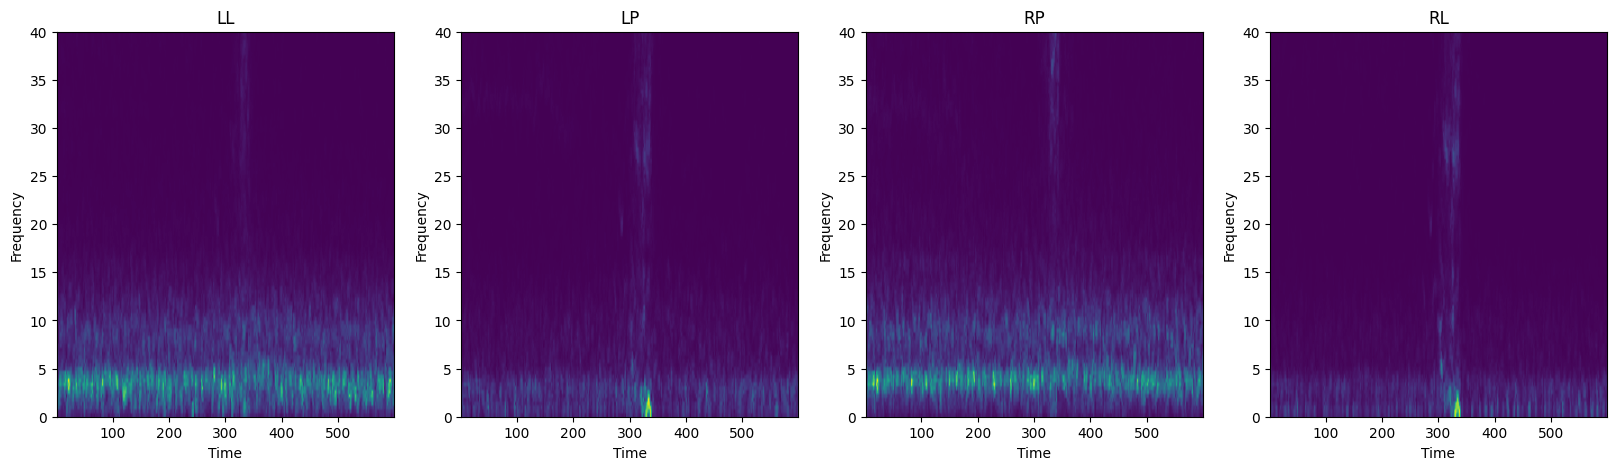

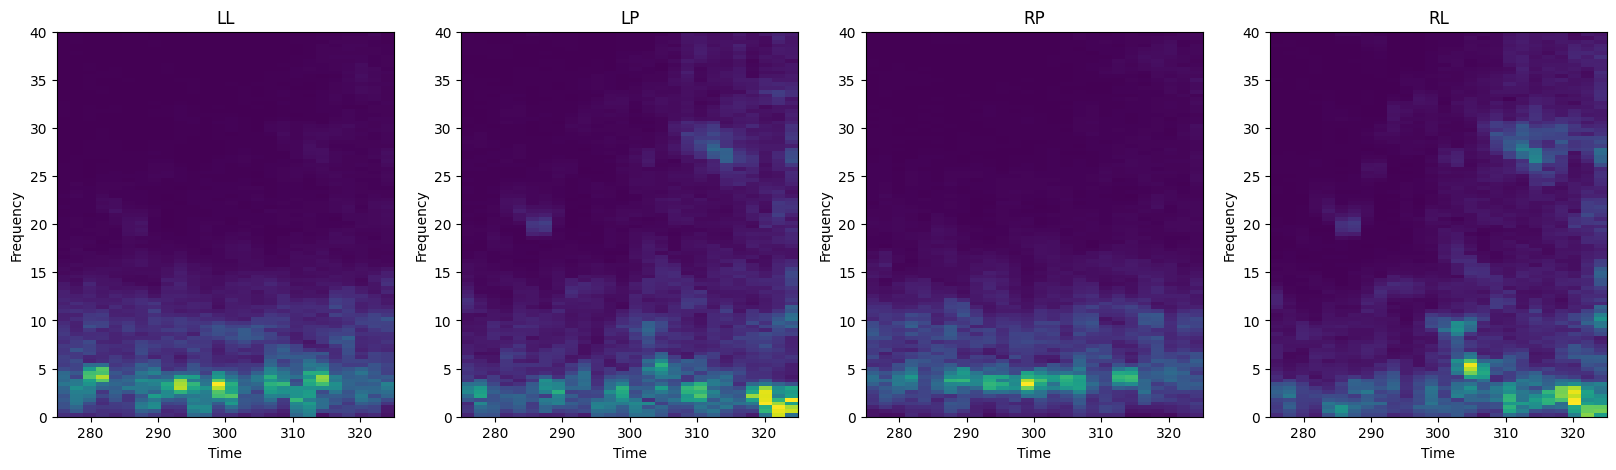

Own Spectrogram Unfiltered


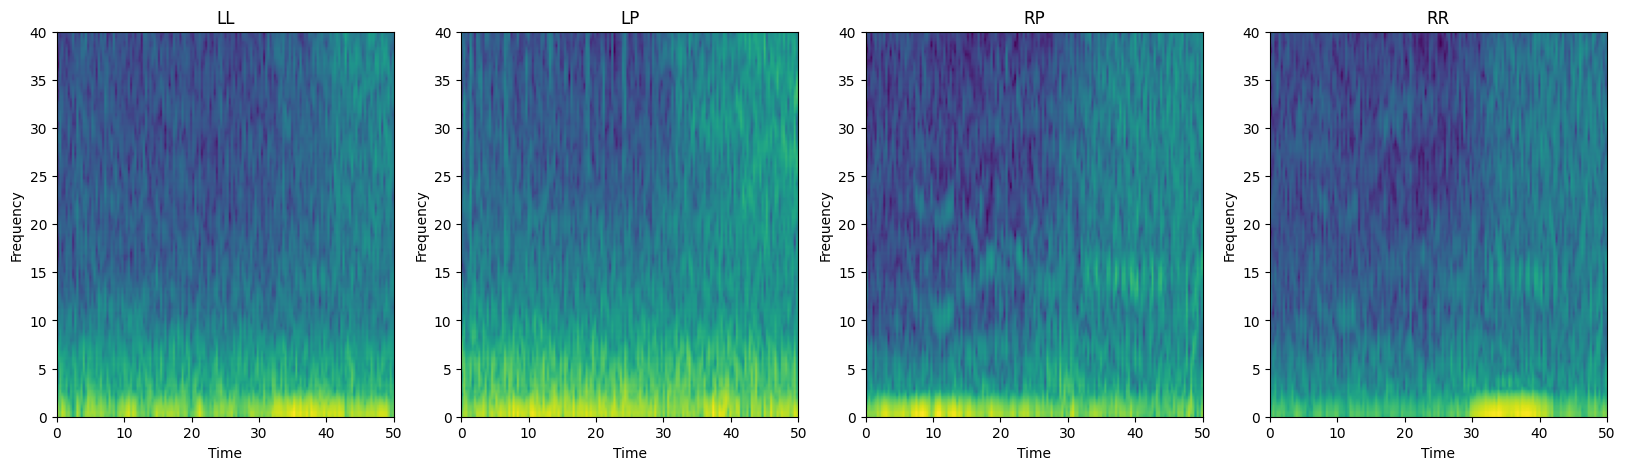

Own Spectrogram Filtered


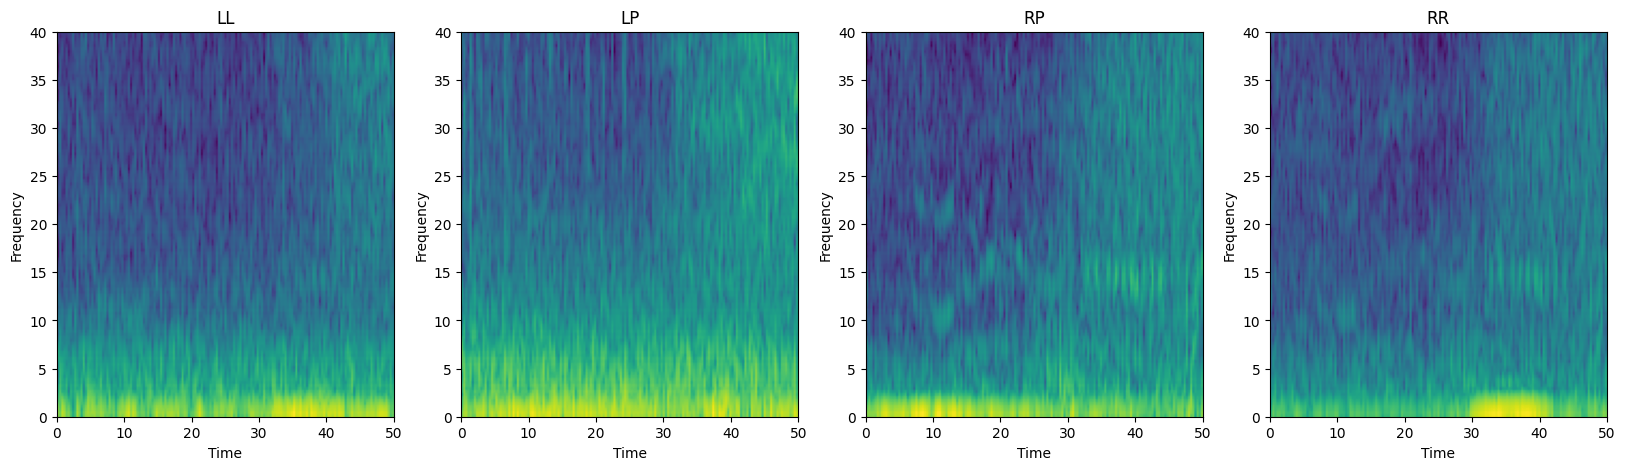

RMSE: 0.04021533578634262


In [100]:

entry = 0
metadata_row = get_metadata().iloc[entry]

eeg_snippet = get_snippet_eeg_by_id(metadata_row.eeg_id, metadata_row.eeg_center)
eeg_full = get_full_eeg_by_id(metadata_row.eeg_id)

print(f'Chosen EEG ID: {metadata_row.eeg_id}')
print(f'Chosen Spectrogram ID: {metadata_row.spectrogram_id}')

print("=====================================")
print("Kaggle Spectrogram")
print("=====================================")
kaggle_spec_600 = get_snippet_spectrogram_by_id(metadata_row.spectrogram_id, metadata_row.spectrogram_center, duration=600)
kaggle_spec_50 = get_snippet_spectrogram_by_id(metadata_row.spectrogram_id, metadata_row.spectrogram_center, duration=50)
visualize_spectrograms(kaggle_spec_600)
visualize_spectrograms(kaggle_spec_50)

print("=====================================")
print("Own Spectrogram Unfiltered")
print("=====================================")


groups = {
    "LL": ['Fp1','F7','T3','T5','O1'],
    "LP": ['Fp1','F3','C3','P3','O1'],
    "RP": ['Fp2','F8','T4','T6','O2'],
    "RR": ['Fp2','F4','C4','P4','O2']
}
own_spec_50 = create_mel_spectrogram(eeg_snippet, groups)
visualize_spectrograms(own_spec_50)

print("=====================================")
print("Own Spectrogram Filtered")
print("=====================================")

groups = {
    "LL": ['Fp1','F7','T3','T5','O1'],
    "LP": ['Fp1','F3','C3','P3','O1'],
    "RP": ['Fp2','F8','T4','T6','O2'],
    "RR": ['Fp2','F4','C4','P4','O2']
}
eeg_filtered = eeg_snippet.apply(lambda x: apply_notch_filter(x, EEG_SAMPLE_RATE, 60), axis=0)
own_spec_50_filtered = create_mel_spectrogram(eeg_filtered, groups)
visualize_spectrograms(own_spec_50_filtered)

print("=====================================")
difference = own_spec_50['LP'] - (own_spec_50_filtered['LP'])
squared_differences = difference ** 2  # Square the differences
mean_squared_error = squared_differences.mean().mean()  # Calculate the mean of the squared differences
rmse = np.sqrt(mean_squared_error)  # Take the square root of the MSE to get the RMSEplt.show()
print(f'RMSE: {rmse}')

Apparently filtering out the 60 Hz signal doesn't matter when using the Mel Transform

# Multiple Spectrograms

Chosen EEG ID: 1628180742
(18000, 20)


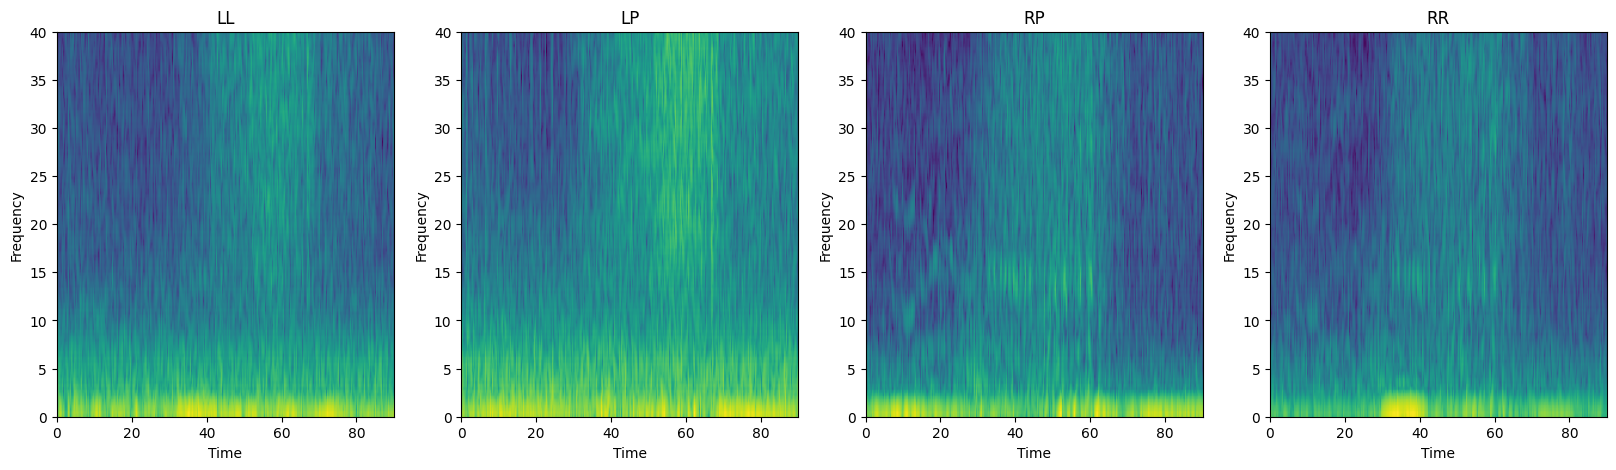

Chosen EEG ID: 2277392603
(10400, 20)


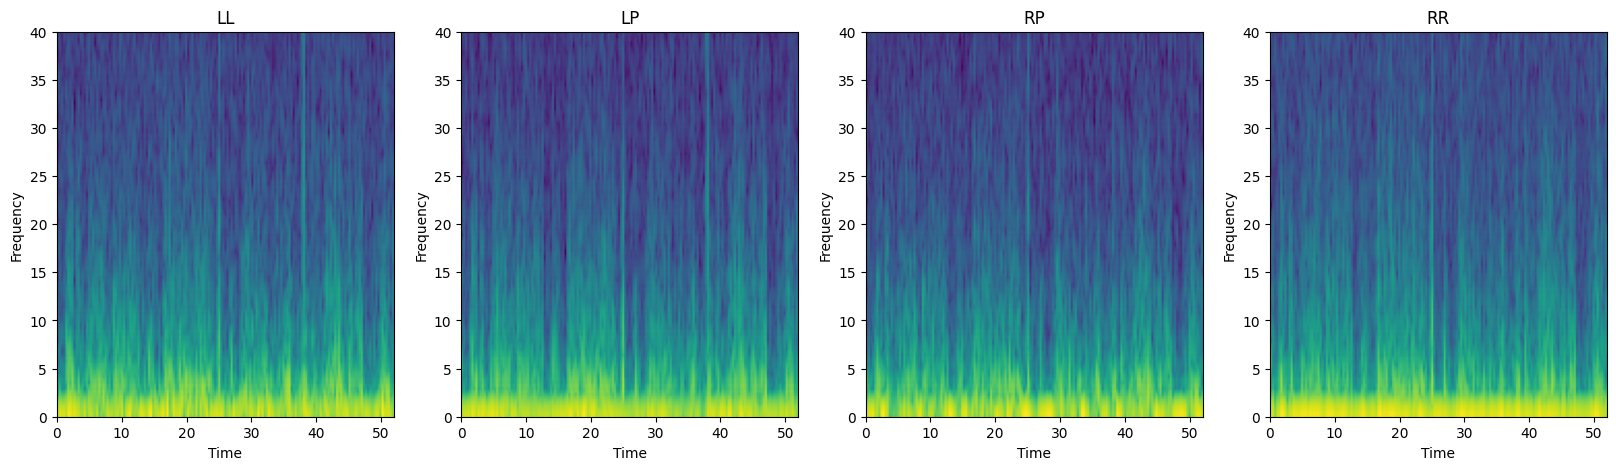

Chosen EEG ID: 722738444
(14800, 20)


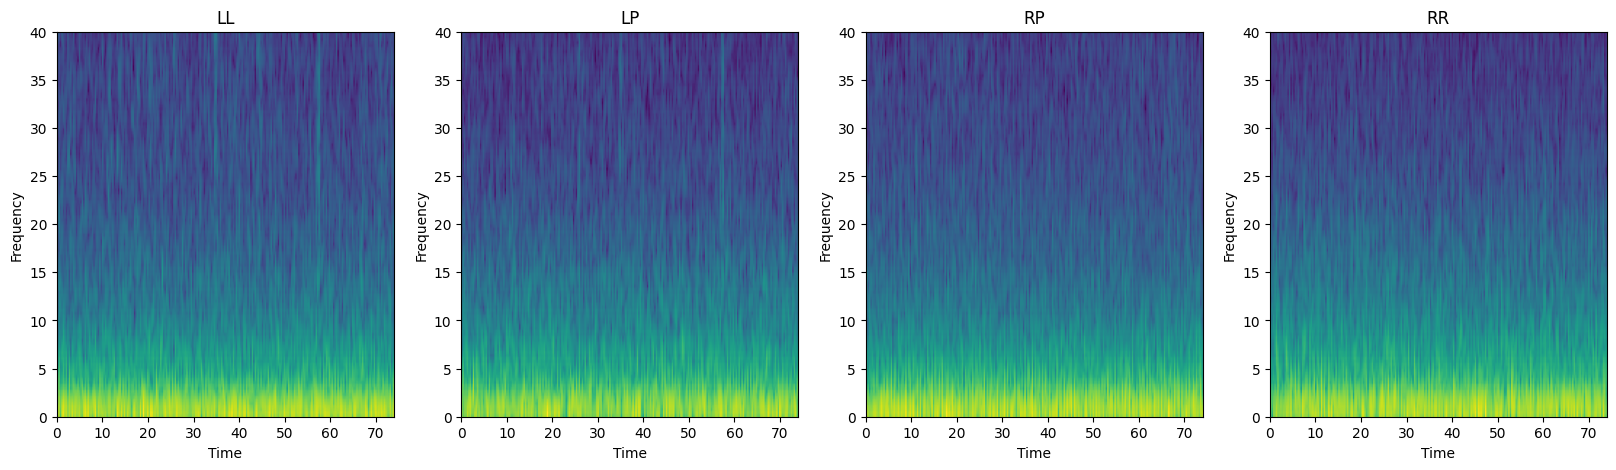

Chosen EEG ID: 387987538
(12400, 20)


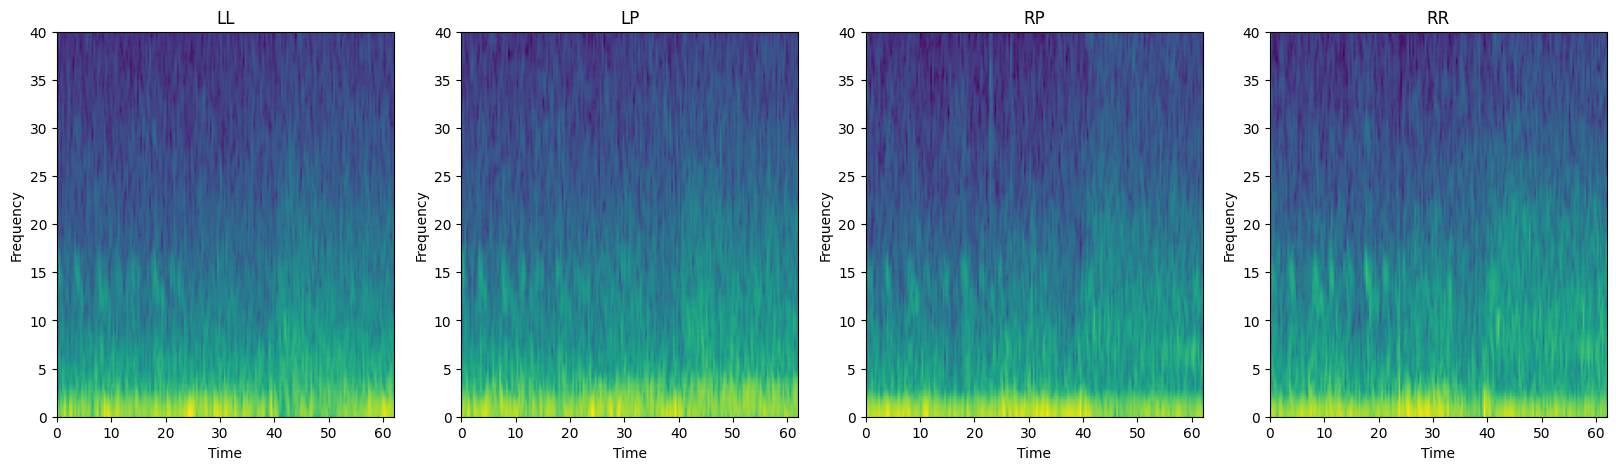

In [ ]:
groups = {
    "LL": ['Fp1','F7','T3','T5','O1'],
    "LP": ['Fp1','F3','C3','P3','O1'],
    "RP": ['Fp2','F8','T4','T6','O2'],
    "RR": ['Fp2','F4','C4','P4','O2']
}


eeg_list = [1628180742, 2277392603, 722738444, 387987538]
for eeg_id in eeg_list:
    print(f'Chosen EEG ID: {eeg_id}')

    eeg = get_full_eeg_by_id(eeg_id)
    print(eeg.shape)
    spec = create_mel_spectrogram(eeg, groups)
    visualize_spectrograms(spec)

In [ ]:
directory_path = DATA_CACHE / 'eeg-spectrograms/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)